In [1]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.preprocessing.text import Tokenizer
from keras.models import Model
import keras

2022-12-19 03:43:08.088796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 03:43:08.267893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-19 03:43:08.267929: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-19 03:43:09.199188: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
import os
import nltk
import pandas as pd
import numpy as np
from sklearn import preprocessing, pipeline, svm, linear_model, neighbors, metrics, ensemble
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from nltk import wordpunct_tokenize, WordNetLemmatizer, sent_tokenize, pos_tag
from nltk.corpus import stopwords as sw, wordnet as wn
import re
import string 
import copy
from unidecode import unidecode

from gensim.models import KeyedVectors
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

dataPath = os.path.join('.', "data")
from pathlib import Path
dataPath = Path(dataPath)

In [3]:
CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

In [4]:
def find_files(search_path):
    result = []
    # Walking top-down from the root
    for root, dir, files in os.walk(search_path):
        for file in files:       
                result.append(os.path.join(root, file))
    return result

def loadData(paths):
    data = pd.DataFrame(columns=["tokens", "label"])
    for i in paths:
        try:
            doc = pd.read_csv(i, sep="\t", names=["tokens", "label"], header=None)
            doc['file'] = i[12:-5]
            data = pd.concat([data, doc], ignore_index=True)
        except Exception as e: 
            print(i, e)
    return data

def stripSpaces(x):
    x = unidecode(x)
    specialchar = "!@#$%^&*()[]{};:,./<>?\|`-~=_+\t\n"
    for tag in specialchar:
        x = x.replace(tag, '')
    x = x.replace(" ", "")
    x = x.lower()
    x = x.strip()
    return x

def cleaning(_dataset, lemma=True, pos=False, verbose=True):
    dataset = _dataset.copy()
    dataset.drop(dataset[dataset["tokens"].isna()].index, inplace=True)
    if verbose: 
        print("Size after Dropping Null Tokens",dataset.shape)
        print("Tokens Without labels:")
    for indexWithNullLabel in dataset[dataset["label"].isna()].index:
        token = dataset["tokens"][indexWithNullLabel]
        #split with ' ' doesnt consider multiple spaces as one
        tokenslist = token.split()
        dataset["tokens"][indexWithNullLabel] = tokenslist[0]

        if (len(tokenslist) > 1):
            dataset["label"][indexWithNullLabel] = tokenslist[1]
        else:
            if verbose:
                print(dataset.loc[indexWithNullLabel, :])
            #Manual Correction for 5467 and 5858 (very & research)
            dataset["label"][indexWithNullLabel] = 'O'
            if verbose:
                print("Manual Corrected:", dataset["tokens"][indexWithNullLabel])
    dataset = dataset.applymap(stripSpaces)
    #label to handel 0, i*, b*, o*, 0*
    dataset[dataset["label"] == 'ii'] = 'i'
    dataset[dataset["label"] == '0'] = 'o'
    if verbose:
        print("Removing special characters")
    specialCharTokens = dataset[~(dataset["tokens"].str.isalnum())]["tokens"].unique()
    #for sprecialChar with label B, moving label to next row and droping rows  
    specialCharWithB = dataset[dataset["tokens"].isin(specialCharTokens) & (dataset["label"] == 'b')].index
    for i in specialCharWithB:
        dataset.loc[i+1, "label"] = 'b'
    dataset.drop(dataset[dataset["tokens"].isin(specialCharTokens) & ((dataset["label"] == 'o') | (dataset["label"] == 'b') )].index, inplace=True)
    #Drop i where there is i and b before it
    toDrop = []
    for i in dataset[dataset["tokens"].isin(specialCharTokens)].index:
        if(dataset["label"][i-1] == 'b' or dataset["label"][i-1] == 'i' ):
            toDrop.append(i)
        else:
            dataset["label"][i] = 'b'
    dataset.drop(toDrop, axis=0, inplace=True)
    if verbose:
        print(dataset.value_counts()[:30])
        print("Removing Stopwords based on above listed most frequent words")
    stopwords = ["about", "all", "also", "among", "at", "available", "be", "because", "been", "both", "but", "by", "can", "each", "first", "has", "have", "here", "how",
             "however", "into", "it", "its", "large", "learn", "many", "may", "more", "most", "much", "new", "not", "often", "only", "or", "other", "over", "recent", "related", "same",
             "several", "shown", "some", "studies", "such", "than", "their", "them", "then", "there", "these", "they", "those", "through", "use", "used", "we", "well", "what",
             "when", "where", "which"]
    if verbose:
        print("Label order correction:")
    dataset.reset_index(drop=True, inplace=True)
    temp = dataset.copy()
    temp["before"] = temp["label"].shift(1)
    temp["after"] = temp["label"].shift(-1)
    for i in temp[(temp["label"] == 'i') & (temp["before"] == 'o') ].index:
            # oio or oii
            if verbose:
                print(temp.loc[i-1, "tokens"]+"("+temp.loc[i-1, "label"]+")\t\t", temp.loc[i, "tokens"]+"("+temp.loc[i, "label"]+")\t\t", temp.loc[i+1, "tokens"]+"("+temp.loc[i+1, "label"]+")")
            if(temp.loc[i+1, "label"] == 'o' or temp.loc[i+1, "label"] == 'i'):
                dataset.loc[i, "label"] = 'b'
            # oib
            if(temp.loc[i+1, "label"] == 'b'):
                dataset.loc[i, "label"] = 'b'
                dataset.loc[i+1, "label"] = 'i'
    del temp
    if verbose:
        print(dataset[(dataset["tokens"].isin(stopwords))]["tokens"].value_counts().index)
    dataset.drop(dataset[dataset["tokens"].isin(stopwords)].index, inplace=True)
    if pos:
        dataset["POS"] = nltk.pos_tag(train["tokens"])
    if lemma:
        lemmatizer = WordNetLemmatizer()
        dataset["tokens"] = dataset["tokens"].apply(lambda x: lemmatizer.lemmatize(x))
    dataset.reset_index(drop=True, inplace=True)
    return dataset

def featurePreparation(_dataset, ref=1):
    dataset = _dataset.copy()
    if  ref == 0:
        dataset["text"] = dataset["tokens"]
    elif ref == 1:
        dataset["text"] = dataset["tokens"].shift(fill_value= "") + " " + dataset["tokens"] \
                            + " " + dataset["tokens"].shift(-1, fill_value= "")
        dataset["label"] = dataset["label"].shift(fill_value= "o") + " " + dataset["label"] \
                            + " " + dataset["label"].shift(-1, fill_value= "o")
    elif ref == 2:
        dataset["text"] = dataset["tokens"].shift(2, fill_value= "") + " " + dataset["tokens"].shift(fill_value= "") \
                            + " " + dataset["tokens"] + " " + dataset["tokens"].shift(-1, fill_value= "") \
                            + " " + dataset["tokens"].shift(-2, fill_value= "")
        dataset["label"] = dataset["label"].shift(2, fill_value= "o") + " " + dataset["label"].shift(fill_value= "o") \
                            + " " + dataset["label"] + " " + dataset["label"].shift(-1, fill_value= "o") \
                            + " " + dataset["label"].shift(-2, fill_value= "o")
        
    elif ref == 3:
        dataset["text"] = dataset["tokens"].shift(3, fill_value= "o") + " " + dataset["tokens"].shift(2, fill_value= "") \
                            + " " + dataset["tokens"].shift(fill_value= "o") + " " + dataset["tokens"] \
                            + " " + dataset["tokens"].shift(-1, fill_value= "o") \
                            + " " + dataset["tokens"].shift(-2, fill_value= "o") + " " + dataset["tokens"].shift(-3, fill_value= "o")
        dataset["label"] = dataset["label"].shift(3, fill_value= "o") + " " + dataset["label"].shift(2, fill_value= "o") \
                            + " " + dataset["label"].shift(fill_value= "o") + " " + dataset["label"] \
                            + " " + dataset["label"].shift(-1, fill_value= "o") \
                            + " " + dataset["label"].shift(-2, fill_value= "o") + " " + dataset["label"].shift(-3, fill_value= "o")
    dataset = dataset.drop(["tokens", "file"], axis=1)
    return dataset

def pre_pipeline(ref=1, pos=False,lemma=True):
    # trainFiles = find_files(dataPath + "\\train")
    # testFiles = find_files(dataPath + "\\test")
    # devFiles = find_files(dataPath + "\\dev")

    trainFiles = find_files(dataPath / "train")
    testFiles = find_files(dataPath / "test")
    devFiles = find_files(dataPath / "dev")
    
    train = loadData(trainFiles)
    test  = loadData(testFiles)
    dev = loadData(devFiles)
    train = cleaning(train, lemma=lemma, pos=pos, verbose=False)
    test = cleaning(test, lemma=lemma, pos=pos, verbose=False)
    dev = cleaning(dev, lemma=lemma, pos=pos, verbose=False)
    train = featurePreparation(train, ref=ref)
    test = featurePreparation(test, ref=ref)
    dev = featurePreparation(dev, ref=ref)
    return train, test, dev

In [5]:
train, test, dev = pre_pipeline(ref=3, lemma=True)
print(train.shape[0], test.shape[0], dev.shape[0])
data = pd.concat([train, test], axis=0, ignore_index=True)
data = pd.concat([data, dev], axis=0, ignore_index=True)

16894 2206 1949


In [6]:
trainSize = train.shape[0]-1
testSize = train.shape[0] + test.shape[0] -1 
devSize = train.shape[0] + test.shape[0] + dev.shape[0] -1

In [7]:
# encode X
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(data["text"])                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(data["text"])  # use the tokeniser to encode input sequence

# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(data["label"])
Y_encoded = tag_tokenizer.texts_to_sequences(data["label"])

In [8]:
Y_encoded[:10]

[[1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 2],
 [1, 1, 1, 1, 1, 2, 3],
 [1, 1, 1, 1, 2, 3, 2],
 [1, 1, 1, 2, 3, 2, 1],
 [1, 1, 2, 3, 2, 1, 2],
 [1, 2, 3, 2, 1, 2, 1],
 [2, 3, 2, 1, 2, 1, 1],
 [3, 2, 1, 2, 1, 1, 1],
 [2, 1, 2, 1, 1, 1, 2]]

In [9]:
# DOWNLOAD: https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300 

# word2vec
path = './GoogleNews-vectors-negative300.bin'

# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

# assign word vectors from word2vec model
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index

# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

MAX_SEQ_LENGTH = 7  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

In [10]:
Y[:10]

array([[1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 2, 3],
       [1, 1, 1, 1, 2, 3, 2],
       [1, 1, 1, 2, 3, 2, 1],
       [1, 1, 2, 3, 2, 1, 2],
       [1, 2, 3, 2, 1, 2, 1],
       [2, 3, 2, 1, 2, 1, 1],
       [3, 2, 1, 2, 1, 1, 1],
       [2, 1, 2, 1, 1, 1, 2]], dtype=int32)

In [11]:
Y = to_categorical(Y)

In [12]:
X_train = X[:trainSize]
X_test = X[trainSize:testSize]
X_validation = X[testSize:]
Y_train = Y[:trainSize]
Y_test = Y[trainSize:testSize]
Y_validation = Y[testSize:]

In [13]:
# total number of tags
NUM_CLASSES = Y.shape[2]

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(32, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['acc'])

# check summary of model
bidirect_model.summary()

2022-12-19 03:43:43.413311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-19 03:43:43.414808: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-19 03:43:43.415728: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s-m2tal): /proc/driver/nvidia/version does not exist
2022-12-19 03:43:43.420709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7, 300)            871800    
                                                                 
 bidirectional (Bidirectiona  (None, 7, 64)            85248     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 7, 4)             260       
 ibuted)                                                         
                                                                 
Total params: 957,308
Trainable params: 957,308
Non-trainable params: 0
_________________________________________________________________


In [14]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=512, epochs=5, validation_data=(X_validation, Y_validation))

Epoch 1/5
33/33 [==============================] - 8s 108ms/step - loss: 0.9504 - acc: 0.6784 - val_loss: 0.6433 - val_acc: 0.7407
Epoch 2/5
33/33 [==============================] - 3s 96ms/step - loss: 0.5154 - acc: 0.7881 - val_loss: 0.4626 - val_acc: 0.8248
Epoch 3/5
33/33 [==============================] - 3s 92ms/step - loss: 0.3184 - acc: 0.8824 - val_loss: 0.4313 - val_acc: 0.8363
Epoch 4/5
33/33 [==============================] - 3s 83ms/step - loss: 0.2405 - acc: 0.9101 - val_loss: 0.4281 - val_acc: 0.8412
Epoch 5/5
33/33 [==============================] - 3s 79ms/step - loss: 0.2017 - acc: 0.9240 - val_loss: 0.4382 - val_acc: 0.8424


Text(0.5, 1.0, 'model accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

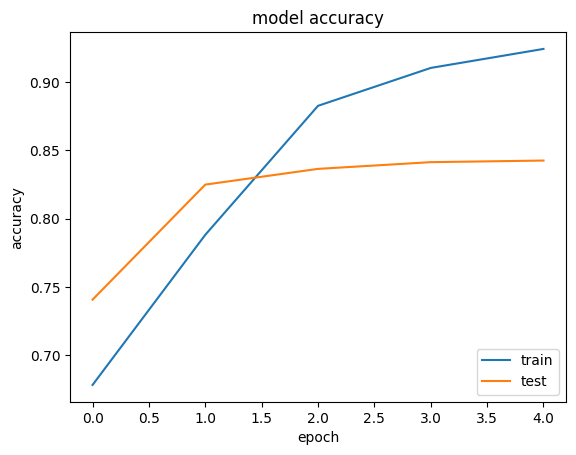

In [15]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [16]:
pre_Y_test = bidirect_model.predict(X_test)

69/69 [==============================] - 2s 8ms/step


In [17]:
loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

69/69 [==============================] - 0s 7ms/step - loss: 0.4402 - acc: 0.8408
Loss: 0.44020429253578186,
Accuracy: 0.8408237099647522


In [18]:
Y_test[0]

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [19]:
pre_Y_test[0]

array([[2.7433669e-03, 6.1069254e-02, 1.1592956e-01, 8.2025784e-01],
       [2.3323407e-04, 9.9339491e-01, 1.6287690e-03, 4.7429968e-03],
       [2.2694790e-04, 1.5520188e-01, 7.9567808e-01, 4.8893098e-02],
       [6.3924649e-04, 3.4160316e-01, 6.5917498e-03, 6.5116584e-01],
       [9.0705231e-05, 9.9537402e-01, 2.0845537e-03, 2.4506135e-03],
       [6.2933468e-05, 9.9320525e-01, 5.8875941e-03, 8.4403681e-04],
       [1.6363802e-04, 9.7728014e-01, 2.0845700e-02, 1.7104095e-03]],
      dtype=float32)

In [20]:
pre = [] 
for i in range(0, pre_Y_test.shape[0]):
    pre.append(np.argmax(pre_Y_test[i], axis=1))

In [21]:
np.argmax(pre_Y_test[0], axis=1)

array([3, 1, 2, 3, 1, 1, 1])

In [22]:
pre[:10]

[array([3, 1, 2, 3, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 2, 3]),
 array([1, 1, 1, 1, 2, 3, 3]),
 array([1, 1, 1, 2, 3, 3, 1]),
 array([1, 1, 2, 3, 3, 1, 1]),
 array([1, 2, 3, 3, 1, 1, 1]),
 array([2, 3, 3, 1, 1, 1, 2]),
 array([3, 3, 1, 1, 1, 2, 3]),
 array([3, 1, 1, 1, 2, 3, 1]),
 array([1, 1, 1, 2, 3, 1, 1])]

In [23]:
# Creating a reverse dictionary
reverse_word_map = dict(map(reversed, tag_tokenizer.word_index.items()))
reverse_word_map

{1: 'o', 2: 'b', 3: 'i'}

In [24]:
# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [25]:
# Creating texts 
my_texts = list(map(sequence_to_text, pre))
my_texts[:10]

[['i', 'o', 'b', 'i', 'o', 'o', 'o'],
 ['o', 'o', 'o', 'o', 'o', 'b', 'i'],
 ['o', 'o', 'o', 'o', 'b', 'i', 'i'],
 ['o', 'o', 'o', 'b', 'i', 'i', 'o'],
 ['o', 'o', 'b', 'i', 'i', 'o', 'o'],
 ['o', 'b', 'i', 'i', 'o', 'o', 'o'],
 ['b', 'i', 'i', 'o', 'o', 'o', 'b'],
 ['i', 'i', 'o', 'o', 'o', 'b', 'i'],
 ['i', 'o', 'o', 'o', 'b', 'i', 'o'],
 ['o', 'o', 'o', 'b', 'i', 'o', 'o']]

In [26]:
labels = []
for i in range(1, len(my_texts)):
    labels.append(" ".join([str(i) for a,i in enumerate(my_texts[i])]))

In [27]:
labels[:10]

['o o o o o b i',
 'o o o o b i i',
 'o o o b i i o',
 'o o b i i o o',
 'o b i i o o o',
 'b i i o o o b',
 'i i o o o b i',
 'i o o o b i o',
 'o o o b i o o',
 'o o b i o o b']

In [28]:
evaluate  = pd.concat([test, pd.Series(labels)], axis=1) 
evaluate

,label,text,0
0,o o o o o b i,o o work in natural language,o o o o o b i
1,o o o o b i i,o work in natural language generation,o o o o b i i
2,o o o b i i o,o work in natural language generation begun,o o o b i i o
3,o o b i i o o,work in natural language generation begun to,o o b i i o o
4,o b i i o o o,in natural language generation begun to take,o b i i o o o
...,...,...,...
2201,o o b i i o o,an approximate polynomial time algorithm for this,o b i i i o o
2202,o b i i o o o,approximate polynomial time algorithm for this...,b i i i o o o
2203,b i i o o o o,polynomial time algorithm for this problem o,b i i o o o o
2204,i i o o o o o,time algorithm for this problem o o,i i o o o o o


In [29]:
wrong = evaluate[evaluate["label"] !=  evaluate[0]].shape[0] 
correct = evaluate[evaluate["label"] ==  evaluate[0]].shape[0]

In [30]:
correct / (wrong + correct)

0.3825929283771532

In [34]:
#hist = clf.fit(trainX.toarray(), trainY.toarray())
#yhat = clf.predict(testX.toarray())

hist = bidirect_training



#d = {'y': test["label"].values, 'yhat': yhat[0].values}

d = {'y': evaluate["label"], 'yhat': evaluate[0]}
print('d:')
d

comparison = pd.DataFrame(data=d)
print('comparison:')
comparison

spanEval = pd.DataFrame( columns=["y", "yhat"])

#spanEval = comparison
print('spanEval:')
spanEval

print(f'{ comparison.shape =}')

d:


{'y': 0       o o o o o b i
 1       o o o o b i i
 2       o o o b i i o
 3       o o b i i o o
 4       o b i i o o o
             ...      
 2201    o o b i i o o
 2202    o b i i o o o
 2203    b i i o o o o
 2204    i i o o o o o
 2205    i o o o o o o
 Name: label, Length: 2206, dtype: object,
 'yhat': 0       o o o o o b i
 1       o o o o b i i
 2       o o o b i i o
 3       o o b i i o o
 4       o b i i o o o
             ...      
 2201    o b i i i o o
 2202    b i i i o o o
 2203    b i i o o o o
 2204    i i o o o o o
 2205              NaN
 Name: 0, Length: 2206, dtype: object}

comparison:


,y,yhat
0,o o o o o b i,o o o o o b i
1,o o o o b i i,o o o o b i i
2,o o o b i i o,o o o b i i o
3,o o b i i o o,o o b i i o o
4,o b i i o o o,o b i i o o o
...,...,...
2201,o o b i i o o,o b i i i o o
2202,o b i i o o o,b i i i o o o
2203,b i i o o o o,b i i o o o o
2204,i i o o o o o,i i o o o o o


spanEval:


,y,yhat


 comparison.shape =(2206, 2)


In [35]:
#'''
for i in range(0, comparison.shape[0]):
    #print('BALRG')
    if(comparison['y'][i] == 'b'):
        j = i+1
        ystr = "b"
        yhatstr = comparison['yhat'][i]
        while(comparison['y'][j] == "i"):
            ystr = ystr + comparison['y'][j]
            yhatstr = yhatstr + comparison['yhat'][j]
            j = j + 1
        toAppend = pd.DataFrame({'y':ystr, 'yhat':yhatstr}, index={1})
        print(f'{ toAppend =}')
        spanEval = pd.concat([spanEval, toAppend], ignore_index=True)
#'''

In [37]:
#spanEval[ (spanEval['y'] == spanEval['yhat']) ].shape[0] / spanEval.shape[0]

#spanEval[ (spanEval['y'] == spanEval['yhat']) & (spanEval['yhat'].str.len() == 1) 
#        ].shape[0] / spanEval[ (spanEval['yhat'].str.len() == 1) 
#                             ].shape[0]
#spanEval[ (spanEval['y'] == spanEval['yhat']) & (spanEval['yhat'].str.len() == 2) 
#        ].shape[0] / spanEval[ (spanEval['yhat'].str.len() == 2)
#                             ].shape[0]
#spanEval[ (spanEval['y'] == spanEval['yhat']) & (spanEval['yhat'].str.len() == 3) 
#        ].shape[0] / spanEval[ (spanEval['yhat'].str.len() == 3) 
#                             ].shape[0]


def spanEvalInd(spanEval, index:int):
    '''correct at that length divided by the total at that length'''
    yEqYhat = spanEval['y'] == spanEval['yhat']
    yhatLenEqInd = spanEval['yhat'].str.len() == index
    ev = \
    spanEval[ (yEqYhat) & (yhatLenEqInd) 
        ].shape[0] / spanEval[ (yhatLenEqInd) 
                             ].shape[0]
    return ev

def spanEvalInd(spanEval, index:int):
    '''correct at that length divided by the total at that length'''
    #yEqYhat = spanEval['y'] == spanEval['yhat']
    
    #yhatLenEqInd = spanEval['yhat'].str.len() == index
    #yhatstr = spanEval['yhat'].str.replace(' ','').str.replace('o','')
    #print(yhatstr)
    
    #yhatLenEqInd = spanEval['yhat'].str.replace(' ','').str.replace('o','').str.len() == index
    #yhatLenEqInd
    
    correct = spanEval[ 
        (spanEval['y'] == spanEval['yhat']) & (spanEval['yhat'].str.replace(' ','',regex=True).str.replace('o','',regex=True).str.len() == index) 
    ].shape[0] 
        
    total = spanEval[ 
        (spanEval['yhat'].str.replace(' ','',regex=True).str.replace('o','',regex=True).str.len() == index) 
    ].shape[0]
    
    return correct / total

spanEvalInd(spanEval, 2)

ZeroDivisionError: division by zero